# Deferred Revenue Forecast COVID

This jupyter notebook contains the details Adobe's deferred revenue forecast model in a more readable, easy to understand format.

The program is run from python directly (versus using a notebook like we have here) and the details are available on my github page www.github.com/davidjsmith44/Deferred_Revenue_Forecast
Note: You will need me to give you access to this repository as it is not public

<b>This is bold text </b>

<i>Italic Text </i>

<blockquote> This is where I have my blockquote text. It will all be indented to make it easier to read </blockquote>

This is not blockquote, but below is a horizontal line
___

<b> Step 1: Process the Base Billings Data </B>


Steps to the program
1. Load up all input data
    - billings history
        - Type A
    - FX rates
    - FX_currency map
    - FX forwards
    - bookings data
 
 
 2. Process the billings data into a dataframe that includes the BU, currency, period and every type of billings based on it's rebill frequency
 
 3. Process the bookings information

4. Forecast the future billings

5. Basic reporting documents

6. Checking for sanity


NOTE: If you plan on using a Jupyter Notebook to run the Deferred Revenue Forecast, you must first download all of the input data to your local directory. I do not yet know how to use a Jupyter Notebook and access data off of the Treasury server.

The input data sits on the Treasury server under Treasury\Financial_Database\Deferred_Revenue\Inputs\Data_YYYY_pMM

There will be 6 files located at this directory that need to be copied to your local drive (preferably where you have installed Anaconda) under a directory called data

## Code Begins here
Below are standard import statements to include all the functionality of numpy, pandas, matplotlib, pickle and a linear regression moodel from sklearn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import pickle
from math import ceil
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d, griddata

## Step 1: Processing Base Billings Data

The billings data comes from tableau and is saved in a file "all_billings_inputs.xlsx" with two sheets of information

"base_billings"
Contains the basic information about all of the billings

In [2]:
df = pd.read_excel('../data/Data_2020_P03/all_billings_inputs_COVID.xlsx', sheet_name='base_billings')

###### Changing the column names early since they are inconsistent across other reports

In [3]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise BU Desc': 'BU',
                                 'Invoice Fiscal Year Period Desc': 'period',
                                 'Product Config Type': 'config',
                                 'Rev Rec Category': 'rev_req_type',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales ( DC )': 'DC_amount',
                                 'Completed Sales': 'US_amount'}, inplace=True)

### To inspect the dataframe we just loaded, you can remove the '#' symbol from the rows below. The # symbol makes the line of code a comment (so the program will not read and execute that line of code). Removing the # will make the line executable and display the results

The df.head(5) command will show the first 5 rows of the billings dataframe. To run this, simply remove the # before this line
 
The df.tail(5) command will show the last 5 rows of the billings dataframe. To run this, simply remove the # before this line

The df.sample(5) command will show a random 5 rows of the rec dataframe. To run this, simply remove the # before this line

Note 1: Only one of these commands can be entered in a single code cell at a time. (So if you remove 2 of the #, only one of the commands will be displayed.

Note 2: The 5 can also be changed, but I think it caps out at 100. For example df.head(30) will show the first 30 rows of the billings dataframe.

Note 3: The code must sit on the far leftmost column of the code window. If there is a space it will cause an error.

In [4]:
#df.head(5)
#df.tail(5)
df.sample(5)

,curr,BU,Frequency,period,config,rev_req_type,rebill_rule,Sales Type,Subscription Term,DC_amount,US_amount
2336,JPY,Experience Cloud,ONGO,2020-06,1Y,D,YA,DEFERRED,12,397760.00,3066.45
3675,USD,Experience Cloud,NaN,2020-06,1Y,NaN,NaN,DEFERRED,12,0.00,0.00
2551,NOK,Creative,NaN,2020-04,NaN,NaN,NaN,DEFERRED,1,-90.00,-8.19
3653,USD,DX Other,ONGO,2020-05,1Y,NaN,YQ,DEFERRED,0,21250.00,21250.00
1801,GBP,Print & Publishing,NaN,2020-06,1Y,D,YA,DEFERRED,12,3945.25,4882.24


### Filtering out any currency that has  < 10 transactions. 
###### To see the list of currencies and how any times they appear in the billings database remove the # before the print(vc) statement

In [5]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()
#print(vc)

#Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index

#### Just keeping track of the currencies we removed in our model_dict data structure

In [6]:
remove_these = vc[vc.values <= 10].index
model_dict = {'curr_removed': list(vc[remove_these].index)}
delete_curr = list(remove_these)
print(model_dict)

{'curr_removed': ['OMR', 'NZD']}


#### The FX database does not have information on the following currencies
 - AED (United Arab Emirates Dirham)
 - BMD (Bermudan Dollar)
 - MXP (Mexican Peso)
 - TRY (Turkish Lira)
 
 Below we are adding the Turkish Lira to our list of currencies that should be removed from the dataframe

In [7]:
if 'TRY' not in model_dict['curr_removed']:
    model_dict['curr_removed'].append('TRY')
    delete_curr.append('TRY')
    a = a.drop('TRY')


###### Clearing out the infrequent currencies from our billings data

In [8]:
df = df[df['curr'].isin(a)]

print('Model dictionary', model_dict)

Model dictionary {'curr_removed': ['OMR', 'NZD', 'TRY']}


In [9]:
print("---Removing infrequent currencies from billings history---")
print('Total number of currencies in the base billings file: ', len(vc))
if len(model_dict['curr_removed'])==0:
    print('No currencies were removed, all contained 10 or more billings')
    print('Currencies in the base billings file')
    for item in a:
        print(a[item], end = " ")
else:
    print('\n Currencies were removed: ', len(model_dict['curr_removed']))

    for item in remove_these:
        print(item, ', ', end="")
        
    print("\n\n{} Remaining currencies: ".format(len(a)))
    for item in a:
        print(item, ', ', end="")

---Removing infrequent currencies from billings history---
Total number of currencies in the base billings file:  35

 Currencies were removed:  3
OMR , NZD , 

32 Remaining currencies: 
USD , EUR , GBP , AUD , JPY , CHF , DKK , SEK , NOK , BRL , HKD , SGD , KRW , RUB , INR , CLP , CAD , PHP , COP , TWD , ARS , PEN , THB , MYR , IDR , ILS , KWD , SAR , BHD , JOD , EGP , LBP , 

#### Removing any of the values that are zero

In [10]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['DC_amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  3987
This is the length of the dataframe after removing zeros:  3866


In [11]:
#df.head(10)
#df.tail(10)
#df.sample(10)

#### Clearing out the Non-Revenue billings from the file
 

In [12]:
df["Sales Type"].value_counts()

DEFERRED       3493
RECOGNIZED      298
PRO-SVC-INV      51
NON-REV          16
Name: Sales Type, dtype: int64

In [13]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))

Length of the dataframe before removing non-revenue billings:  3866
Length of the dataframe after removing non-revenue billings:   3850



## Grouping the billings by sales type

Grouping the data by the <b> Sales Type </b> field
 - <i>'RECOGNIZED'</i> sales are perpetual and go straight to revenue without hitting deferred 
 - <i>'PRO-SVC-INV'</i> professional services that are invoiced and go to revenue directly when invoiced
 - <i>'DEFERRED'</i> sales that will sit on the balance sheet in deferred revenue and amortize over their life
 
 #### Below we are creating a seperate dataframe for each of the Sales Types


In [14]:
rec = df[df['Sales Type']=='RECOGNIZED'].copy()
svc = df[df['Sales Type']=='PRO-SVC-INV'].copy()
dfr = df[df['Sales Type']=='DEFERRED'].copy()

print('Total number of billings:              ', len(df))
print("Number of recognized revenue billings: ", len(rec))
print("Number of service invoiced billings:   ", len(svc))
print("Number of deferred revenue billings:   ", len(dfr))

Total number of billings:               3850
Number of recognized revenue billings:  298
Number of service invoiced billings:    51
Number of deferred revenue billings:    3493


### Recognized Revenue

The rec.head(5) command will show the first 5 elements of the rec dataframe. To run this, simply remove the # before this line
 
The rec.tail(5) command will show the last 5 elements of the rec dataframe. To run this, simply remove the # before this line

The rec.sample(5) command will show the a random 5 elements of the rec dataframe. To run this, simply remove the # before this line

Note: Only one of these commands can be entered in a single code cell at a time. 

Note: The 5 can also be changed, but I think it caps out at 100

In [15]:
#rec.head(5)
#rec.tail(5)
#rec.sample(5)

##### Below we are grouping the rec dataframe by Currency, Business Unit and Period and cleaning up the data we do not need. Since the recognized revenue go directly to revenue, there is no contract that will renew and need to be modeled in the future.

In [16]:
# testing groupby object
gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [17]:
#gb_rec.head(10)
#gb_rec.tail(10)
#gb_rec.sample(10)

### Service Billings

##### Below we are grouping the svc dataframe by Currency, Business Unit and Period and cleaning up the data we do not need. Since the service billings go directly to revenue, there is no contract that will renew and need to be modeled in the future.

In [18]:
gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)

In [19]:
#gb_svc.head(5)
#gb_svc.tail(5)
#gb_svc.sample(5)

### Deffered Billings

#### Type B Billings 
Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months. Since these billings do not have a contract that will renew in the future, there is no need to model a rebillings of these service based billings


In [20]:
dfr_b = dfr[dfr['rev_req_type']=='B'].copy()
gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [21]:
#gb_b.head(5)
#gb_b.tail(25)
#gb_b.sample(5)

#### Type A Billings

These billings are on a billing plan. The product config tells us how long before they renew

 - '3Y' = 36 months
 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)


In [22]:
dfr_a = dfr[dfr['rev_req_type']=='A'].copy()

gb_a = dfr_a.groupby(['curr', 'BU', 'period',
                     'config'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [23]:
#gb_a.head(20)
#gb_a.tail(20)
#gb_a.sample(20)

In [24]:
gb_a['config'].value_counts()

1Y       67
2Y       30
3Y       13
MTHLY     6
OUNIV     5
Name: config, dtype: int64

#### Below is just a check to see how large the billing types are across all periods

In [25]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

,config,DC_amount,US_amount
0,1Y,6.530233e+09,4.244484e+08
1,2Y,2.768885e+07,9.635676e+05
2,3Y,1.424745e+08,6.293950e+05
3,MTHLY,1.574775e+06,1.574775e+06
4,OUNIV,2.859288e+04,3.043323e+04


###### These 'OCONS', 'OENSV', 'ONORE' and 'OUNIV' config types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [26]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
gb_a_config = gb_a[gb_a['config'].isin(config_list)]

###### Grouping by the config type into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M dataframes


In [27]:
gb_a_1Y = gb_a_config[gb_a_config['config']=='1Y'].copy()
gb_a_2Y = gb_a_config[gb_a_config['config']=='2Y'].copy()
gb_a_3Y = gb_a_config[gb_a_config['config']=='3Y'].copy()
gb_a_1M = gb_a_config[gb_a_config['config']=='MTHLY'].copy()

In [28]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  6
this is the lenght of type A 1Y billings:  67
this is the lenght of type A 2Y billings:  30
this is the lenght of type A 3Y billings:  13


In [29]:
#gb_a_2Y.head(5)
#gb_a_1M.tail(5)
#gb_a_3Y.sample(5)

#### TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly:        *{Y1, Y2, Y3, Y5}*
 - Quarterly:      *YQ*
 - Every 4 months: *YT*  --NOTE: There are only 10 of these, so I am treating these as quarterly--
 - Semi-annual:    *YH*
 - Annual:         *{YA, YC}*
 - Every 2 years:  *Y4*
 - Every 3 years:  *Y7*
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [30]:
dfr_d = dfr[dfr['rev_req_type']=='D'].copy()

gb_d = dfr_d.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [31]:
gb_d['rebill_rule'].value_counts()

YA    238
Y3    204
YQ     46
YC     24
YH     20
Y1     20
YM     10
Y2      5
Y4      4
YX      4
Y7      3
YY      1
Name: rebill_rule, dtype: int64

###### Grouping these by rebill rule and incorporating rebill rules that have the same rebill period

In [32]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'YM'])].copy()
gb_d_mthly.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_mthly = gb_d_mthly.groupby(['curr', 'BU', 'period']).sum()
gb_d_mthly.reset_index(inplace=True)

gb_d_qtrly = gb_d[gb_d['rebill_rule'].isin(['YQ', 'YY', 'YT'])].copy()
gb_d_qtrly.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_qtrly = gb_d_qtrly.groupby(['curr', 'BU', 'period']).sum()
gb_d_qtrly.reset_index(inplace=True)

gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']

gb_d_annual = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC', 'YX'])].copy()
gb_d_annual.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_annual = gb_d_annual.groupby(['curr', 'BU', 'period']).sum()
gb_d_annual.reset_index(inplace=True)

gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']
gb_d_three_yrs = gb_d[gb_d['rebill_rule']=='Y7']

In [33]:
#gb_d_qtrly.head(10)
#gb_d_annual.tail(10)
#gb_d_three_yrs.head(10)

In [34]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))
print('Length of three years', len(gb_d_three_yrs))

Length of monthly 216
Length of quarterly 46
Length of semi ann 20
Length of annual 238
Length of two years 4
Length of three years 3


## Building a single dataframe that incorporates all of this data

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency Billing Amount
   - USD Billing Amount
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

###### Below uses functions to merge a list of dataframes and move billings amounts to the correct category based on rebill frequency and type


In [35]:
list_df = [gb_rec, gb_svc, gb_b,
           gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
           gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs, gb_d_three_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
        'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
        'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d', 'deferred_3Y_d']


In [36]:
def sum_USD_amt(list_df, list_columns):
    total_US = []
    for df in list_df:
        total_US.append(df['US_amount'].sum())
    total_df = pd.DataFrame(index = list_columns, columns = ['US_amounts'], data=total_US)
    return total_df

In [37]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        #print('This is i:', i)
        #print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0].copy()
            df_merged.rename(index=str, columns={'DC_amount': list_columns[i]+'_DC', 
                                                 'US_amount': list_columns[i]+'_US'}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [38]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [39]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # DC columns first
    # Monthly
    df['deferred_1M_DC'] = df['deferred_1M_a_DC']+df['deferred_1M_d_DC']
    df.drop(labels=['deferred_1M_a_DC', 'deferred_1M_d_DC'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_DC'] = df['deferred_1Y_a_DC']+df['deferred_1Y_d_DC']
    df.drop(labels=['deferred_1Y_a_DC', 'deferred_1Y_d_DC'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_DC'] = df['deferred_2Y_a_DC']+df['deferred_2Y_d_DC']
    df.drop(labels=['deferred_2Y_a_DC', 'deferred_2Y_d_DC'], axis=1, inplace=True)
    
    #Three-Year
    df['deferred_3Y_DC'] = df['deferred_3Y_a_DC']+df['deferred_3Y_d_DC']
    df.drop(labels=['deferred_3Y_a_DC', 'deferred_3Y_d_DC'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_DC':'deferred_3M_DC', 
                               'deferred_6M_d_DC': 'deferred_6M_DC'}, inplace=True)

    # US columns
    # Monthly
    df['deferred_1M_US'] = df['deferred_1M_a_US']+df['deferred_1M_d_US']
    df.drop(labels=['deferred_1M_a_US', 'deferred_1M_d_US'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_US'] = df['deferred_1Y_a_US']+df['deferred_1Y_d_US']
    df.drop(labels=['deferred_1Y_a_US', 'deferred_1Y_d_US'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_US'] = df['deferred_2Y_a_US']+df['deferred_2Y_d_US']
    df.drop(labels=['deferred_2Y_a_US', 'deferred_2Y_d_US'], axis=1, inplace=True)
    
    # Three-Year
    df['deferred_3Y_US'] = df['deferred_3Y_a_US']+df['deferred_3Y_d_US']
    df.drop(labels=['deferred_3Y_a_US', 'deferred_3Y_d_US'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_US':'deferred_3M_US', 
                               'deferred_6M_d_US': 'deferred_6M_US'}, inplace=True)

    
    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

##### The code below uses the functions above to merge all of the dataframes and clean up the columns

In [40]:
df = merge_all_dataframes(list_df, list_columns)

df = clean_df_columns(df)

## I NEED TO CREATE A BETTER PRESENTATION OF THIS CHECK THAT EVERYTHING MATCHES!!!!

## Need to create a summary report with totals coming from every area to make sure the totals I have make sense

In [41]:
df.sum()

curr              ARSARSARSAUDAUDAUDAUDAUDAUDAUDAUDAUDAUDAUDAUDA...
BU                CreativeCreativeCreativeCreativeCreativeCreati...
period            2020-042020-052020-062020-042020-052020-062020...
recognized_DC                                           1.24338e+09
recognized_US                                           1.45639e+08
service_DC                                               6.7736e+07
service_US                                              3.18046e+07
deferred_B_DC                                           4.90688e+08
deferred_B_US                                           4.06135e+07
deferred_3M_DC                                          7.89801e+07
deferred_3M_US                                          7.47816e+07
deferred_6M_DC                                          4.27054e+07
deferred_6M_US                                          3.78052e+06
deferred_1M_DC                                          1.65416e+10
deferred_1Y_DC                                  

In [42]:
total_df = sum_USD_amt(list_df, list_columns)
total_df

,US_amounts
recognized,1.456387e+08
service,3.180455e+07
deferred_B,4.061348e+07
deferred_1M_a,1.574775e+06
deferred_1Y_a,4.244484e+08
deferred_2Y_a,9.635676e+05
deferred_3Y_a,6.293950e+05
deferred_1M_d,4.345503e+08
deferred_3M_d,7.478163e+07
deferred_6M_d,3.780523e+06


In [43]:
total_df.loc['deferred_1M_d']+total_df.loc['deferred_1M_a']

US_amounts    4.361251e+08
dtype: float64

In [44]:
# Make this a function to be cleaned up somehow
del dfr
del dfr_a
del dfr_b
del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_qtrly, gb_d_semi_ann


# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)


###### Loading up the Adobe Financial Calendar to get period start and end dates

In [45]:
# loading Adobe financial calendar and calculating period weeks
df_cal = pd.read_excel('../data/old/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')
df_cal['Period_Weeks'] = (df_cal['Per_End']-df_cal['Per_Start'])/np.timedelta64(1, 'W')
df_cal['Period_Weeks']=df_cal['Period_Weeks'].astype(int)
df_cal['Period_Weeks'] = df_cal['Period_Weeks']+1

In [46]:
#df_cal.head(5)
#df_cal.sample(5)
#df_cal.tail(5)

___
## Type A No Config Type Billings
___

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

#### Steps
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe


###### Note: This file contains two different start date and end date columns. At least one of these columns is populated

In [47]:
df_A = pd.read_excel('../data/Data_2020_P03/all_billings_inputs_COVID.xlsx', sheet_name='type_A_no_config')

In [48]:
df_A.rename(index=str, columns={'Document Currency':'curr', 
                               'Enterprise BU Desc':'BU',
                               'Invoice Fiscal Year Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales ( DC )':'DC_amount',
                               'Completed Sales': 'US_amount'
                               }, inplace=True)



In [49]:
df_A.head(5)
#df_A.sample(5)
#df_A.tail(5)

,curr,BU,period,end_date_1,end_date_2,start_date_1,start_date_2,DC_amount,US_amount
0,AUD,Creative,2020-04,NaT,2020-03-20,NaT,2020-02-21,4356.77,2563.26
1,AUD,Creative,2020-04,NaT,2020-03-21,NaT,2020-02-22,4845.58,2850.85
2,AUD,Creative,2020-04,NaT,2020-03-22,NaT,2020-02-23,4485.10,2638.77
3,AUD,Creative,2020-04,NaT,2020-03-23,NaT,2020-02-24,4937.18,2904.74
4,AUD,Creative,2020-04,NaT,2020-03-24,NaT,2020-02-25,3836.10,2256.93


##### Removing banned currencies
model_dict

In [50]:
def remove_bad_currencies(df, model_dict):
    this_list = df['curr'].unique().tolist()
    
    for curr in model_dict['curr_removed']:
        if curr in this_list:
            print('need to ban this currency: ', curr)
            df = df[df['curr']!= curr]
    return df


In [51]:
df_A = remove_bad_currencies(df_A, model_dict)

###### Handling the duplicate dates by taking a max and creating a start_date and end_date fields in pandas datetime format

In [52]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(str)

df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2',
                  'start_date_str', 'end_date_str'], axis=1, inplace=True)

###### Creating a month_interval field that calculates the difference between the start_date and end_date in months. We will map this number of months into a rebilling frequency (this number of months determines when the contract expires and the deferred revenue model assumes that all attribution is accounted for in our net new billings estimates provided by FP&A)

In [53]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

In [54]:
#df_A.head(10)
df_A.sample(10)
#df_A.tail(10)

,curr,BU,period,DC_amount,US_amount,start_date,end_date,month_interval,months
309,USD,Print & Publishing,2020-04,5750.00,5750.00,2020-03-19,2021-03-18,364 days,12.0
307,USD,Print & Publishing,2020-04,1620.00,1620.00,2020-03-16,2021-03-15,364 days,12.0
241,USD,Creative,2020-05,8798.61,8798.61,2020-04-05,2020-05-04,29 days,1.0
168,GBP,Print & Publishing,2020-05,119.94,143.58,2020-04-03,2020-05-02,29 days,1.0
291,USD,Print & Publishing,2020-04,2580.00,2580.00,2020-03-18,2020-04-17,30 days,1.0
256,USD,Creative,2020-05,42.34,42.34,2020-04-04,2021-04-03,364 days,12.0
158,GBP,Print & Publishing,2020-04,159.92,188.84,2020-03-22,2020-04-21,30 days,1.0
137,EUR,Print & Publishing,2020-06,3754.00,4070.61,2020-05-09,2020-06-08,30 days,1.0
270,USD,Other Solutions,2020-04,2500.00,2500.00,2020-03-11,2021-03-10,364 days,12.0
287,USD,Print & Publishing,2020-04,3200.00,3200.00,2020-03-13,2020-04-12,30 days,1.0


##### Mapping the number of months into our common rebill frequencies (monthly, quarterly, semi-annual, annual, 2 years and 3 years)


In [55]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill

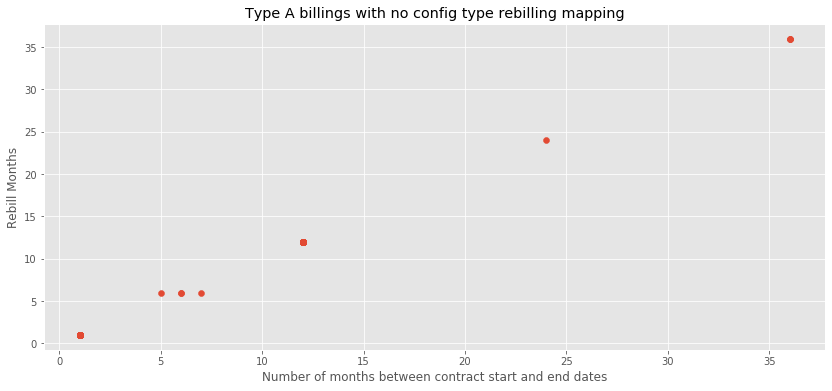

In [56]:
fig, axs = plt.subplots(1,1, figsize=(14,6))
axs.scatter(df_A['months'], df_A['rebill_months'])
axs.set_ylabel('Rebill Months')
axs.set_xlabel('Number of months between contract start and end dates')
axs.set_title('Type A billings with no config type rebilling mapping')
print_text = 'No'

In [57]:
#df_A.head(10)
#df_A.sample(10)
#df_A.tail(10)

###### Dropping the columns we no longer need

In [58]:
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

###### Grouping the dataframe by rebill_months using a pivot table

In [59]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp_DC = df_A.pivot_table('DC_amount', ['curr', 'BU', 'period'], 'rebill_months')
temp_US = df_A.pivot_table('US_amount', ['curr', 'BU', 'period'], 'rebill_months')

###### Filling in any zeros that arise if there is no contract on a specific period, currency and BU for a particular rebill period

In [60]:
temp_DC = temp_DC.fillna(0)
temp_US = temp_DC.fillna(0)

###### Flattening the pivot table back to a normal dataframe and renaming the columns

In [61]:
temp_flat_DC = pd.DataFrame(temp_DC.to_records())
temp_flat_US = pd.DataFrame(temp_US.to_records())

In [62]:
temp_flat_DC.rename(index=str, columns={'1.0':'deferred_1M_DC', 
                               '3.0':'deferred_3M_DC',
                               '6.0':'deferred_6M_DC',
                               '12.0':'deferred_1Y_DC',
                               '24.0':'deferred_2Y_DC',
                               '36.0': 'deferred_3Y_DC'}, inplace=True)

temp_flat_US.rename(index=str, columns={'1.0':'deferred_1M_US', 
                               '3.0':'deferred_3M_US',
                               '6.0':'deferred_6M_US',
                               '12.0':'deferred_1Y_US',
                               '24.0':'deferred_2Y_US',
                               '36.0': 'deferred_3Y_US'}, inplace=True)

In [63]:
#temp_flat_DC.head(20)
#temp_flat_US.sample(20)
#temp_flat_DC.tail(20)

###### Quick check that we have not created duplicate column entries (for example two entries for a period with same BU and currency)

In [64]:
df_test_dup = df.copy()
orig_len = len(df_test_dup)
print("Original Length of the dataframe before duplicate test: ", orig_len)

df_test_dup =df_test_dup.drop_duplicates(subset=['curr', 'BU', 'period'])
print('New length of database after duplicates have been removed: ',len(df_test_dup))

if orig_len!=len(df_test_dup):
    print('We had duplicates in the dataframe! Look into why')

Original Length of the dataframe before duplicate test:  279
New length of database after duplicates have been removed:  279


###### Merging the billings dataframe with the temp_flat_DC dataframe and and temp_flat_US dataframe and filling in any blanks with zero

In [65]:
df_with_A = pd.merge(df, temp_flat_DC, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'], indicator=True, validate='one_to_one')

df_with_A = df_with_A.fillna(pd.Series(0, index=df_with_A.select_dtypes(exclude='category').columns))

In [66]:
df_with_all = pd.merge(df_with_A, temp_flat_US, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])

df_with_all = df_with_all.fillna(pd.Series(0, index=df_with_all.select_dtypes(exclude='category').columns))

In [67]:
#df_with_all.head(10)
df_with_all.sample(10)
#df_with_all.tail(10)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC,...,deferred_6M_DC_y,deferred_1Y_DC_y,deferred_2Y_DC_y,deferred_3Y_DC_y,_merge,deferred_1M_US_y,deferred_6M_US_y,deferred_1Y_US_y,deferred_2Y_US_y,deferred_3Y_US_y
240,NOK,Print & Publishing,2020-05,0.00,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0
265,GBP,DX Other,2020-06,0.00,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0
18,BRL,Creative,2020-06,28739.00,5266.10,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0
57,EUR,Document Cloud,2020-04,1748871.91,1936352.30,0.0,0.0,0.0,0.0,309308.26,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0
104,JPY,Print & Publishing,2020-05,9981334.00,92071.97,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0
169,USD,Other Solutions,2020-05,-8290.42,-8290.42,0.0,0.0,0.0,0.0,0.00,...,0.0,2500.0,0.0,0.0,both,0.0,0.0,2500.0,0.0,0.0
253,SAR,Document Cloud,2020-06,0.00,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0
162,USD,Document Cloud,2020-05,10519192.87,10519192.87,0.0,0.0,20000.0,20000.0,62582.41,...,0.0,0.0,0.0,0.0,both,0.0,0.0,0.0,0.0,0.0
25,CHF,Creative,2020-04,61689.00,64257.85,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0
103,JPY,Print & Publishing,2020-04,15085554.00,139435.94,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,left_only,0.0,0.0,0.0,0.0,0.0


In [68]:
df_with_all.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_3M_DC',
       'deferred_3M_US', 'deferred_6M_DC_x', 'deferred_6M_US_x',
       'deferred_1M_DC_x', 'deferred_1Y_DC_x', 'deferred_2Y_DC_x',
       'deferred_3Y_DC_x', 'deferred_1M_US_x', 'deferred_1Y_US_x',
       'deferred_2Y_US_x', 'deferred_3Y_US_x', 'deferred_1M_DC_y',
       'deferred_6M_DC_y', 'deferred_1Y_DC_y', 'deferred_2Y_DC_y',
       'deferred_3Y_DC_y', '_merge', 'deferred_1M_US_y', 'deferred_6M_US_y',
       'deferred_1Y_US_y', 'deferred_2Y_US_y', 'deferred_3Y_US_y'],
      dtype='object')

###### Combining columns form the different data sources (they get merged with different names) and cleaning up the columns

In [69]:
df_with_all['deferred_1M_DC']= df_with_all['deferred_1M_DC_x']+df_with_all['deferred_1M_DC_y']
#df_with_all['deferred_3M_DC']= df_with_all['deferred_3M_DC_x']+df_with_all['deferred_3M_DC_y']
df_with_all['deferred_6M_DC']= df_with_all['deferred_6M_DC_x']+df_with_all['deferred_6M_DC_y']
df_with_all['deferred_1Y_DC']= df_with_all['deferred_1Y_DC_x']+df_with_all['deferred_1Y_DC_y']
df_with_all['deferred_2Y_DC']= df_with_all['deferred_2Y_DC_x']+df_with_all['deferred_2Y_DC_y']
df_with_all['deferred_3Y_DC']= df_with_all['deferred_3Y_DC_x']+df_with_all['deferred_3Y_DC_y']

df_with_all['deferred_1M_US']= df_with_all['deferred_1M_US_x']+df_with_all['deferred_1M_US_y']
#df_with_all['deferred_3M_US']= df_with_all['deferred_3M_US_x']+df_with_all['deferred_3M_US_y']

df_with_all['deferred_6M_US']= df_with_all['deferred_6M_US_x']+df_with_all['deferred_6M_US_y']
df_with_all['deferred_1Y_US']= df_with_all['deferred_1Y_US_x']+df_with_all['deferred_1Y_US_y']
df_with_all['deferred_2Y_US']= df_with_all['deferred_2Y_US_x']+df_with_all['deferred_2Y_US_y']
df_with_all['deferred_3Y_US']= df_with_all['deferred_3Y_US_x']+df_with_all['deferred_3Y_US_y']

df_with_all.drop(labels = ['deferred_1M_DC_x','deferred_1M_DC_y',
                        #'deferred_3M_DC_x','deferred_3M_DC_y',
                        'deferred_6M_DC_x','deferred_6M_DC_y',
                        'deferred_1Y_DC_x','deferred_1Y_DC_y',
                        'deferred_2Y_DC_x','deferred_2Y_DC_y',
                        'deferred_3Y_DC_x','deferred_3Y_DC_y',
                        'deferred_1M_US_x','deferred_1M_US_y',   
                        #'deferred_3M_US_x','deferred_3M_US_y',
                        'deferred_6M_US_x','deferred_6M_US_y',
                        'deferred_1Y_US_x','deferred_1Y_US_y',
                        'deferred_2Y_US_x','deferred_2Y_US_y',
                        'deferred_3Y_US_x','deferred_3Y_US_y'],
                         axis=1, inplace=True)

In [70]:
#df_with_all.head(5)
df_with_all.sample(5)
#df_with_all.tail(5)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC,...,deferred_1M_DC,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
77,GBP,Experience Cloud,2020-06,400040.81,497564.05,65750.0,81235.44,-41714.0,-54506.78,669515.91,...,0.00,322358.0,4176529.88,0.0,0.0,0.00,398279.75,5164320.01,0.0,0.0
116,NOK,Document Cloud,2020-05,5279.00,485.77,0.0,0.00,0.0,0.00,0.00,...,113818.37,0.0,381656.81,0.0,0.0,10865.78,0.00,35865.74,0.0,0.0
270,CAD,Document Cloud,2020-05,0.00,0.00,0.0,0.00,0.0,0.00,0.00,...,0.00,0.0,1119938.75,0.0,0.0,0.00,0.00,790142.89,0.0,0.0
258,SGD,Document Cloud,2020-06,0.00,0.00,0.0,0.00,0.0,0.00,0.00,...,4446.15,0.0,9682.92,0.0,0.0,3132.69,0.00,6808.94,0.0,0.0
215,ILS,Document Cloud,2020-06,0.00,0.00,0.0,0.00,0.0,0.00,0.00,...,2288.00,0.0,12204.00,0.0,0.0,649.74,0.00,3467.81,0.0,0.0


###### Checking totals to se if they match what we expect

In [71]:
print('sum of temp flat DC 1M:      ', temp_flat_DC['deferred_1M_DC'].sum())
print('sum of base_df before DC 1M: ', df['deferred_1M_DC'].sum())
print('sum of final DC 1M:          ', df_with_all['deferred_1M_DC'].sum())

a = temp_flat_DC['deferred_1M_DC'].sum()
b = df['deferred_1M_DC'].sum()
c = df_with_all['deferred_1M_DC'].sum()
print(c)
print(a+b)

sum of temp flat DC 1M:       44973.05967750795
sum of base_df before DC 1M:  16541598879.070002
sum of final DC 1M:           16541643852.12968
16541643852.12968
16541643852.129679


# TO BE DONE: Create a table that contains the total billings by DC for each dataframe and each step for auditing

 - start with all of the DC
 - then create function that appends and adds rows
 - then do the same for the DC stuff type_A
 - then check the totals


##### Renaming the cleaned billings dataframe as df_billings

In [76]:
df_billings = df_with_all.copy()
df_billings.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_3M_DC',
       'deferred_3M_US', '_merge', 'deferred_1M_DC', 'deferred_6M_DC',
       'deferred_1Y_DC', 'deferred_2Y_DC', 'deferred_3Y_DC', 'deferred_1M_US',
       'deferred_6M_US', 'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US'],
      dtype='object')

###### Checking that there are no bilings from future periods in this dataframe. If so, drop them

In [77]:
#drop_index= df_billings[df_billings['period']=='2020-04'].index
#df_billings.drop(drop_index, inplace=True)

##### Sorting the dataframe and saving this dataframe for use later in a pickle file

In [78]:
df_billings = df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))

with open('../data/processed/COVID_billings.p', 'wb') as f:
    pickle.dump(df_billings, f)  

### Loading All of the other information we need here from excel files
 - currency_map: contain a mapping of currency the majority of our billings in each country
 - FX_data: contains current spot rates, FX forward rates and FX volatilities
 - FX_forward_rates: contains the forward rates used in the FP&A Plan
 - Bookings Forecast: contains the most recent FP&A net new booking forecast (usually only one fiscal year included)

###### Currency Map

In [79]:
df_curr_map = pd.read_excel("../data/currency_map.xlsx", sheet_name="curr_map")
df_curr_map["Country"] = df_curr_map["Country"].str.replace("\(MA\)", "", case=False)

##### FX data

In [80]:
df_FX_rates = pd.read_excel('../data/FX_data.xlsx', sheet_name='to_matlab')
df_FX_rates['VOL_3M'] = df_FX_rates['VOL_3M']/100
df_FX_rates['VOL_6M'] = df_FX_rates['VOL_6M']/100
df_FX_rates['VOL_9M'] = df_FX_rates['VOL_9M']/100
df_FX_rates['VOL_1Y'] = df_FX_rates['VOL_1Y']/100

In [81]:
#df_FX_rates.head(5)
#df_FX_rates.sample(5)
#df_FX_rates.tail(5)

###### FX Forward Rates used in the FP&A Plan

In [82]:
df_FX_fwds = pd.read_excel('../data/FX_forward_rates.xlsx', sheet_name='forward_data', 
                          skiprows = 1, usecols="C,G")

df_FX_fwds.rename(index=str, columns={'Unnamed: 2': 'curr', 'FWD REF':'forward'}, inplace=True)

In [83]:
# Remove the # below to see the entire list of FX_fwds in the plan
#df_FX_fwds

##### Bookings Forecast

In [84]:
df_bookings = pd.read_excel('../data/2020_bookings_fcst_Q1.xlsx', sheet_name='bookings')

In [85]:
#df_bookings.head(10)
#df_bookings.sample(10)
#df_bookings.tail(10)

### Cleaning up the bookings data
 - remove odd strings such as '(EB)' from BU, (IS) from Internal Segment, etc
 - dropping columns we do not need
 - renaming columns to better match our data naming convention
 
 NOTE: The '('  and ')' is a special character so we need to precede these with the escape character '\'

In [86]:
df_bookings['EBU'] = df_bookings['EBU'].str.replace(' \(EB\)', '', case=False)
df_bookings['Internal Segment'] = df_bookings['Internal Segment'].str.replace('\(IS\)', '')
df_bookings['PMBU'] = df_bookings['PMBU'].str.replace('\(PMBU\)', '')
df_bookings['GEO'] = df_bookings['GEO'].str.replace('\(G\)', '')
df_bookings['Market Area'] = df_bookings['Market Area'].str.replace('\(MA\)', '')

In [87]:
df_bookings.drop(columns = ['Hedge', 'Mark Segment', 'Type', 'Scenario', 'FX'], inplace = True)

df_bookings.rename(index=str, columns = {'EBU': 'BU', 
                                        'Internal Segment': 'segment',
                                        'PMBU': 'product',
                                        'GEO':'geo',
                                        'Market Area': 'country',
                                        'Bookings Type': 'booking_type',
                                        'value': 'US_amount'}, inplace =True)

In [88]:
#df_bookings.head(10)
#df_bookings.sample(10)
#df_bookings.tail(10)

###### The cell below shows samples of what is in the data. Removing one of the parenthesis will execute the code. (One at a time)

In [89]:
#df_bookings['BU'].value_counts()
#df_bookings['segment'].value_counts()
#df_bookings['product'].value_counts()
#df_bookings['country'].value_counts()
#df_bookings['booking_type'].value_counts()

##### Merging the bookings country data to a currency using the currency map dataframe (df_curr_map)

In [90]:
df_curr_map

,Country,Currency
0,Aus and New Zealand,AUD
1,Benelux,EUR
2,Brazil,USD
3,Canada,USD
4,China,USD
5,Eastern Europe,EUR
6,France,EUR
7,Germany,EUR
8,Hong Kong & Taiwan,USD
9,Iberica,EUR


In [91]:
list_book_ctry = df_bookings['country'].unique()
print('Countries in the bookings file: \n', list_book_ctry)

list_curr_map = df_curr_map['Country'].unique()
print('Countries in the currency map file: \n', list_curr_map)


Countries in the bookings file: 
 ['Aus and New Zealand ' 'Benelux ' 'Brazil ' 'Canada ' 'China '
 'Eastern Europe ' 'France ' 'Germany ' 'Hong Kong & Taiwan ' 'Iberica '
 'India ' 'Italy ' 'Japan ' 'Korea ' 'Mediterranean ' 'Mexico '
 'Middle East ' 'Nordic ' 'Russia & CIS ' 'Southeast Asia '
 'SSA & Israel ' 'Strat. Latin America ' 'Switzerland ' 'United Kingdom '
 'United States ']
Countries in the currency map file: 
 ['Aus and New Zealand ' 'Benelux ' 'Brazil ' 'Canada ' 'China '
 'Eastern Europe ' 'France ' 'Germany ' 'Hong Kong & Taiwan ' 'Iberica '
 'India ' 'Italy ' 'Japan ' 'Korea ' 'Mediterranean ' 'Mexico '
 'Middle East ' 'Nordic ' 'Russia & CIS ' 'Southeast Asia '
 'SSA & Israel ' 'Strat. Latin America ' 'Switzerland ' 'Taiwan '
 'United Kingdom ' 'United States ']


##### Checking that we have the currency mapping for every country where we have a bookings forecast

In [92]:
a = list(set(list_book_ctry) & set(list_curr_map))

not_in_map = set(list_book_ctry).difference(set(list_curr_map))
if len(not_in_map)!=0:
    print('There is a bookings currency that is not in the currency map!\nWe need to look into the currency map file and add this!')
else:
    print('The bookings currencies are in the currency map. OK to merge the dataframes.')

The bookings currencies are in the currency map. OK to merge the dataframes.


###### Merge the bookings forecast with the currency map

In [93]:
df_bookings = pd.merge(df_bookings, df_curr_map, how='left', left_on='country', right_on='Country')

In [94]:
#df_bookings.head(10)
#df_bookings.sample(10)
#df_bookings.tail(10)

### Adding periods weeks (from the Adobe calendar) to the billings dataframe

In [95]:
#df_cal.head(10)
#df_cal.sample(10)
#df_cal.tail(10)

##### Creating a column in df_cal with year  '-' the last two digits of the per_ticker to match with the billings dataframe

In [96]:
df_cal['p2digit']=df_cal['Period'].astype(str)
df_cal['p2digit']=df_cal['p2digit'].str.zfill(2)

df_cal['period_match']=df_cal['Year'].astype(str) + '-' + df_cal['p2digit'].astype(str)

df_cal.drop(['p2digit'],axis=1, inplace=True)

In [97]:
#df_cal.head(10)
#df_cal.sample(10)
#df_cal.tail(10)

##### Getting the calendar ready to be merged with the df_billings dataframe by removing columns that are not needed

In [98]:
df_cal_2_merge = df_cal.copy()
df_cal_2_merge.drop(['Year', 'Quarter', 'Period', 'Qtr_Ticker', 'Qtr_Start', 'Qtr_End', 'Per_Start',
                     'Per_Ticker','Per_End'], axis=1, inplace=True)

##### Merging the calendar periods with the periods in the df_billings dataframe to bring over period weeks

In [99]:
df_billings = df_billings.merge(df_cal_2_merge, how='left', left_on='period', right_on='period_match')
df_billings.drop(['period_match', '_merge'], axis=1, inplace=True)

In [100]:
df_billings.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_3M_DC',
       'deferred_3M_US', 'deferred_1M_DC', 'deferred_6M_DC', 'deferred_1Y_DC',
       'deferred_2Y_DC', 'deferred_3Y_DC', 'deferred_1M_US', 'deferred_6M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US', 'Period_Weeks'],
      dtype='object')

In [132]:
#df_billings.head(10)
#df_billings.sample(5)
df_billings.tail(5)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC,...,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US,Period_Weeks
268,USD,Experience Cloud,2020-05,25379749.56,25379749.56,11413793.50,11413793.50,14303962.97,14303962.97,22250468.85,...,1087615.5,5.579587e+07,-84960.00,0.0,2.237048e+06,1087615.5,5.574030e+07,-84960.00,0.0,4.0
269,USD,Experience Cloud,2020-06,2659755.60,2659755.60,1399506.69,1399506.69,3151922.09,3151922.09,2683197.67,...,50610.0,1.689142e+07,0.00,0.0,9.492056e+04,50610.0,1.689142e+07,0.00,0.0,5.0
276,USD,Print & Publishing,2020-04,684593.15,684593.15,0.00,0.00,33333.00,33333.00,108234.18,...,0.0,6.885219e+06,43475.00,0.0,3.495923e+05,0.0,6.885219e+06,43475.00,0.0,4.0
277,USD,Print & Publishing,2020-05,1656955.97,1656955.97,0.00,0.00,0.00,0.00,8250.00,...,2700.0,8.434223e+06,115691.81,0.0,6.212760e+04,2700.0,8.434223e+06,115691.81,0.0,4.0
278,USD,Print & Publishing,2020-06,6698272.59,6698272.59,0.00,0.00,0.00,0.00,0.00,...,25425.0,2.432728e+06,37690.50,0.0,6.982499e+04,25425.0,2.432728e+06,37690.50,0.0,5.0


##### Saving these dataframes in as a python dictionary in the pickle file 'all_inputs.p'

In [102]:
df_billings=df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))

input_df_dict = {'model_dict': model_dict,
                 'billings':df_billings, 
                 'ADBE_cal':df_cal,
                 'bookings': df_bookings,
                 'FX_forwards': df_FX_fwds,
                 'FX_rates': df_FX_rates
                }

pickle.dump(input_df_dict, open('../data/processed/all_inputs_COVID.p', 'wb'))

# Adding the deferred forecast to the df_billings to compare the actuals with the forecast 

In [133]:
fcst_dict = pickle.load(open('../data/processed/initial_forecast.p', 'rb'))
df_fcst = fcst_dict['forecast']

In [134]:
df_fcst.head(10)

,curr,BU,period,recognized_DC,service_DC,deferred_B_DC,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,...,deferred_6M__US,deferred_1Y__US,deferred_2Y__US,deferred_3Y__US,deferred_1M_US,deferred_3M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
0,ARS,Creative,2020-04,0.00,0.0,0.0,1.835209e+07,0.0,0.0,1112854.12,...,0,0,0,0,281826.091681,0.0,0.0,17089.676820,0.0,0.0
1,ARS,Creative,2020-05,0.00,0.0,0.0,1.972401e+07,0.0,0.0,1595808.00,...,0,0,0,0,291566.159398,0.0,0.0,23589.702654,0.0,0.0
2,ARS,Creative,2020-06,0.00,0.0,0.0,2.636992e+07,0.0,0.0,1654238.00,...,0,0,0,0,375754.937710,0.0,0.0,23571.863177,0.0,0.0
3,ARS,Creative,2020-07,6786.00,0.0,0.0,2.246786e+07,0.0,0.0,953875.89,...,0,0,0,0,307852.569710,0.0,0.0,13069.923230,0.0,0.0
4,ARS,Creative,2020-08,16472.00,0.0,0.0,2.383978e+07,0.0,0.0,963180.00,...,0,0,0,0,314564.807679,0.0,0.0,12709.118067,0.0,0.0
5,ARS,Creative,2020-09,19205.00,0.0,0.0,3.151462e+07,0.0,0.0,2263704.00,...,0,0,0,0,400997.595536,0.0,0.0,28803.768392,0.0,0.0
6,ARS,Creative,2020-10,30382.19,0.0,0.0,2.658362e+07,0.0,0.0,1318346.81,...,0,0,0,0,330735.397287,0.0,0.0,16401.979290,0.0,0.0
7,ARS,Creative,2020-11,59049.00,0.0,0.0,2.795554e+07,0.0,0.0,1494162.20,...,0,0,0,0,340240.521630,0.0,0.0,18185.108938,0.0,0.0
8,ARS,Creative,2020-12,71355.57,0.0,0.0,3.665933e+07,0.0,0.0,3154860.03,...,0,0,0,0,436676.306451,0.0,0.0,37579.868566,0.0,0.0
9,ARS,Creative,2021-01,79224.95,0.0,0.0,3.837423e+07,0.0,0.0,916705.92,...,0,0,0,0,439610.620247,0.0,0.0,10501.675079,0.0,0.0


In [137]:
df_billings.head(10)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC,...,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US,Period_Weeks
0,ARS,Creative,2020-04,67878.0,1082.16,0.0,0.0,0.0,0.0,0.0,...,0.0,3007741.60,0.0,0.0,284671.82,0.0,48020.59,0.0,0.0,4.0
1,ARS,Creative,2020-05,141104.0,2183.71,0.0,0.0,0.0,0.0,0.0,...,0.0,2723624.63,0.0,0.0,83672.17,0.0,41686.44,0.0,0.0,4.0
2,ARS,Creative,2020-06,71292.0,1069.81,0.0,0.0,0.0,0.0,0.0,...,0.0,1489773.70,0.0,0.0,89110.38,0.0,22231.63,0.0,0.0,5.0
18,ARS,DX Other,2020-04,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
19,ARS,DX Other,2020-05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
17,ARS,DX Other,2020-06,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
3,ARS,Document Cloud,2020-04,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,292456.00,0.0,0.0,3885.48,0.0,4668.36,0.0,0.0,4.0
4,ARS,Document Cloud,2020-05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,540944.00,0.0,0.0,3367.34,0.0,8346.82,0.0,0.0,4.0
5,ARS,Document Cloud,2020-06,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,228842.49,0.0,0.0,2937.28,0.0,3423.57,0.0,0.0,5.0
107,ARS,Experience Cloud,2020-04,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0


### Start by looking at document currency billings 

##### Creating forecast slice that only contains the Q2 periods

In [141]:
these_periods = ['2020-04', '2020-05', '2020-06']
print(len(df_fcst))
df_fcst2 = df_fcst[df_fcst['period'].isin(these_periods)]
print(len(df_fcst2))

1620
405


In [142]:
df_fcst2.head(10)

,curr,BU,period,recognized_DC,service_DC,deferred_B_DC,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,...,deferred_6M__US,deferred_1Y__US,deferred_2Y__US,deferred_3Y__US,deferred_1M_US,deferred_3M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
0,ARS,Creative,2020-04,0.0,0.0,0.0,1.835209e+07,0.0,0.0,1112854.12,...,0,0,0,0,281826.091681,0.0,0.0,17089.676820,0.0,0.0
1,ARS,Creative,2020-05,0.0,0.0,0.0,1.972401e+07,0.0,0.0,1595808.00,...,0,0,0,0,291566.159398,0.0,0.0,23589.702654,0.0,0.0
2,ARS,Creative,2020-06,0.0,0.0,0.0,2.636992e+07,0.0,0.0,1654238.00,...,0,0,0,0,375754.937710,0.0,0.0,23571.863177,0.0,0.0
12,ARS,DX Other,2020-04,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00,...,0,0,0,0,0.000000,0.0,0.0,0.000000,0.0,0.0
13,ARS,DX Other,2020-05,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00,...,0,0,0,0,0.000000,0.0,0.0,0.000000,0.0,0.0
14,ARS,DX Other,2020-06,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00,...,0,0,0,0,0.000000,0.0,0.0,0.000000,0.0,0.0
24,ARS,Document Cloud,2020-04,0.0,0.0,0.0,2.201944e+05,0.0,0.0,102846.00,...,0,0,0,0,3381.441013,0.0,0.0,1579.366847,0.0,0.0
25,ARS,Document Cloud,2020-05,0.0,0.0,0.0,2.364945e+05,0.0,0.0,136742.00,...,0,0,0,0,3495.931290,0.0,0.0,2021.360414,0.0,0.0
26,ARS,Document Cloud,2020-06,0.0,0.0,0.0,3.159933e+05,0.0,0.0,178324.00,...,0,0,0,0,4502.708257,0.0,0.0,2541.006149,0.0,0.0
36,ARS,Experience Cloud,2020-04,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00,...,0,0,0,0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [143]:
df_fcst = df_fcst2.copy()

In [144]:
df_billings.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_3M_DC',
       'deferred_3M_US', 'deferred_1M_DC', 'deferred_6M_DC', 'deferred_1Y_DC',
       'deferred_2Y_DC', 'deferred_3Y_DC', 'deferred_1M_US', 'deferred_6M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US', 'Period_Weeks'],
      dtype='object')

In [145]:
df_fcst.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'service_DC', 'deferred_B_DC',
       'deferred_1M_DC', 'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC',
       'deferred_2Y_DC', 'deferred_3Y_DC', 'Period_Weeks', 'r_squared',
       'intercept', 'coeff', 'X_length', 'is_forecast', 'recognized_US',
       'service_US', 'deferred_B_US', 'deferred_1M_a_US', 'deferred_1Y_a_US',
       'deferred_2Y_a_US', 'deferred_3Y_a_US', 'deferred_1M_d_US',
       'deferred_3M_d_US', 'deferred_6M_d_US', 'deferred_1Y_d_US',
       'deferred_2Y_d_US', 'deferred_3Y_d_US', 'recognized__US', 'service__US',
       'deferred_B__US', 'deferred_1M__US', 'deferred_3M__US',
       'deferred_6M__US', 'deferred_1Y__US', 'deferred_2Y__US',
       'deferred_3Y__US', 'deferred_1M_US', 'deferred_3M_US', 'deferred_6M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US'],
      dtype='object')

In [146]:
list_curr = df_fcst.curr.unique()
list_curr2 = df_billings.curr.unique()
print(list_curr)
print(list_curr2)


['ARS' 'AUD' 'BRL' 'CAD' 'CHF' 'CLP' 'COP' 'DKK' 'EUR' 'GBP' 'HKD' 'IDR'
 'ILS' 'INR' 'JPY' 'KRW' 'MYR' 'NOK' 'NZD' 'PEN' 'PHP' 'RUB' 'SEK' 'SGD'
 'THB' 'TWD' 'USD']
['ARS' 'AUD' 'BHD' 'BRL' 'CAD' 'CHF' 'CLP' 'COP' 'DKK' 'EGP' 'EUR' 'GBP'
 'HKD' 'IDR' 'ILS' 'INR' 'JOD' 'JPY' 'KRW' 'KWD' 'LBP' 'MYR' 'NOK' 'PEN'
 'PHP' 'RUB' 'SAR' 'SEK' 'SGD' 'THB' 'TWD' 'USD']


In [147]:
set1 = set(list_curr)
set2 = set(list_curr2)
diff = set2.difference(set1)
print(diff)

{'SAR', 'KWD', 'EGP', 'JOD', 'BHD', 'LBP'}


In [148]:
# Sum all deferred billings by type (ignoring currency) and we will work with the US amounts
df_fcst_US = df_fcst.groupby(by=['period']).sum()
df_fcst_US.head(10)


,recognized_DC,service_DC,deferred_B_DC,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,Period_Weeks,...,deferred_6M__US,deferred_1Y__US,deferred_2Y__US,deferred_3Y__US,deferred_1M_US,deferred_3M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
period,,,,,,,,,,,,,,,,,,,,,
2020-04,7.109896e+08,52212386.23,9.799431e+07,1.112211e+10,37182075.78,42633465.60,4.823355e+09,6179768.59,315.0,540,...,0,0,0,0,3.092892e+08,3.536177e+07,2.851216e+06,3.387645e+08,8.033113e+05,315.0
2020-05,4.524074e+08,77671251.67,3.637910e+08,1.182901e+10,54641339.61,16464875.33,8.401475e+09,1407029.06,0.0,540,...,0,0,0,0,3.139448e+08,5.340726e+07,2.435014e+06,3.862944e+08,9.447786e+05,0.0
2020-06,5.679855e+08,97137585.61,1.354863e+08,1.566990e+10,46566703.82,30287977.35,7.000895e+09,3622287.58,350475.0,675,...,0,0,0,0,3.982534e+08,4.068603e+07,3.849351e+06,5.511206e+08,1.994248e+06,350475.0


In [149]:
df_fcst.columns


Index(['curr', 'BU', 'period', 'recognized_DC', 'service_DC', 'deferred_B_DC',
       'deferred_1M_DC', 'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC',
       'deferred_2Y_DC', 'deferred_3Y_DC', 'Period_Weeks', 'r_squared',
       'intercept', 'coeff', 'X_length', 'is_forecast', 'recognized_US',
       'service_US', 'deferred_B_US', 'deferred_1M_a_US', 'deferred_1Y_a_US',
       'deferred_2Y_a_US', 'deferred_3Y_a_US', 'deferred_1M_d_US',
       'deferred_3M_d_US', 'deferred_6M_d_US', 'deferred_1Y_d_US',
       'deferred_2Y_d_US', 'deferred_3Y_d_US', 'recognized__US', 'service__US',
       'deferred_B__US', 'deferred_1M__US', 'deferred_3M__US',
       'deferred_6M__US', 'deferred_1Y__US', 'deferred_2Y__US',
       'deferred_3Y__US', 'deferred_1M_US', 'deferred_3M_US', 'deferred_6M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US'],
      dtype='object')